In [1]:
import pickle
import numpy as np
from multigraph import MultiGraph

with open('adj_graph.pkl', 'rb') as inobj:
    op_graph = pickle.load(inobj)

a_graph = op_graph.get_adjacency_matrix()

In [2]:
import keras
from keras.models import Sequential, Model, model_from_json
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation
#load the saved embeddings
# load json and create model
json_file = open('sym_model.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model
model.load_weights("sym_model.h5")
print("Loaded model from disk")

Using Theano backend.


Loaded model from disk


In [3]:
model.compile(optimizer='adam', loss='mse')
embedding = model.predict(a_graph)

In [4]:
# Each node in the AIFB dataset is either a person, a project, a publication, a group, etc.
# Here we get a list of all of the nodes that have a certain label and put them in a dictionary
import re
publications = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Publikationen\/viewPublikationOWL\/id[0-9]*instance)>")
authors = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Personen\/viewPersonOWL\/id[0-9]*instance)>")
groups = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Forschungsgruppen\/viewForschungsgruppeOWL\/id[0-9]*instance)>")
projects = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Projekte\/viewProjektOWL\/id[0-9]*instance)>")
subjects = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Forschungsgebiete\/viewForschungsgebietOWL\/id[0-9]*instance)>")
organizations = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Kooperationen\/viewOrganizationOWL\/id[0-9]*instance)>")

regex_dict = {"publications":publications, "authors":authors, 
              "groups":groups, "projects": projects, "subjects": subjects,
              "organizations":organizations}

from collections import defaultdict
categories = defaultdict(set)

In [5]:
with open("aifb_csv/aifb_stripped.nt") as f:
    for line in f:
        for k,reg in regex_dict.iteritems():
            finds = reg.match(line)
            if finds != None:
                categories[k].add(finds.group(1))

for k,v in categories.iteritems():
    print(k,len(v))

('organizations', 28)
('subjects', 146)
('publications', 1232)
('groups', 5)
('authors', 237)
('projects', 78)


In [6]:
import random
#get the embeddings for 100 instances from each category
subset_embeddings = []
subset_labels = []
label_enum = list(enumerate(categories.keys(),1))
label_dict = {j: i for i,j in label_enum}

for k,v in categories.iteritems():
    samples = random.sample(v, min(len(v), 100))
    for s in samples:
        #print(s,embedding[op_graph.nodes[s]])
        subset_embeddings.append(embedding[op_graph.nodes[s]])
        subset_labels.append(label_dict[k])
print(label_enum)

[(1, 'organizations'), (2, 'subjects'), (3, 'publications'), (4, 'groups'), (5, 'authors'), (6, 'projects')]


In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import gensim


#from https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229
def tsnescatterplot(vectors, vector_labels, labels):
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(vectors)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    # display scatter plot   
    cmap = plt.cm.rainbow
    norm = mcolors.Normalize(vmin=0, vmax=len(labels))
    plt.figure(figsize=(8,6),dpi=200)
    plt.scatter(x_coords, y_coords, alpha=0.85, c=[cmap(norm(i)) for i in vector_labels])
    #draw the legend
    patches = []
    for l in labels:
        patches.append(mpatches.Patch(color=cmap(norm(l[0])), label=l[1]))
    plt.legend(handles=patches)
    #scatterpoints=1, loc='lower left', ncol=3, fontsize=8

    #for label, x, y in zip(vector_labels, x_coords, y_coords):
    #    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()-5.5, x_coords.max()+5.5)
    plt.ylim(y_coords.min()-5.5, y_coords.max()+5.5)
    plt.show()


In [8]:
def pcascatterplot(vectors, vector_labels, labels):
            
    # find tsne coords for 2 dimensions
    pca = PCA(n_components=2)
    np.set_printoptions(suppress=True)
    Y = pca.fit_transform(vectors)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    cmap = plt.cm.rainbow
    norm = mcolors.Normalize(vmin=0, vmax=len(labels))
    # display scatter plot
    plt.figure(figsize=(8,6),dpi=200)
    plt.scatter(x_coords, y_coords,alpha=0.5, c=[cmap(norm(i)) for i in vector_labels])
    
   #draw the legend
    patches = []
    for l in labels:
        patches.append(mpatches.Patch(color=cmap(norm(l[0])), label=l[1]))
        plt.legend(handles=patches)
    #scatterpoints=1, loc='lower left', ncol=3, fontsize=8
    
    #for label, x, y in zip(vector_labels, x_coords, y_coords):
    #    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()-5.5, x_coords.max()+5.5)
    plt.ylim(y_coords.min()-5.5, y_coords.max()+5.5)
    plt.show()

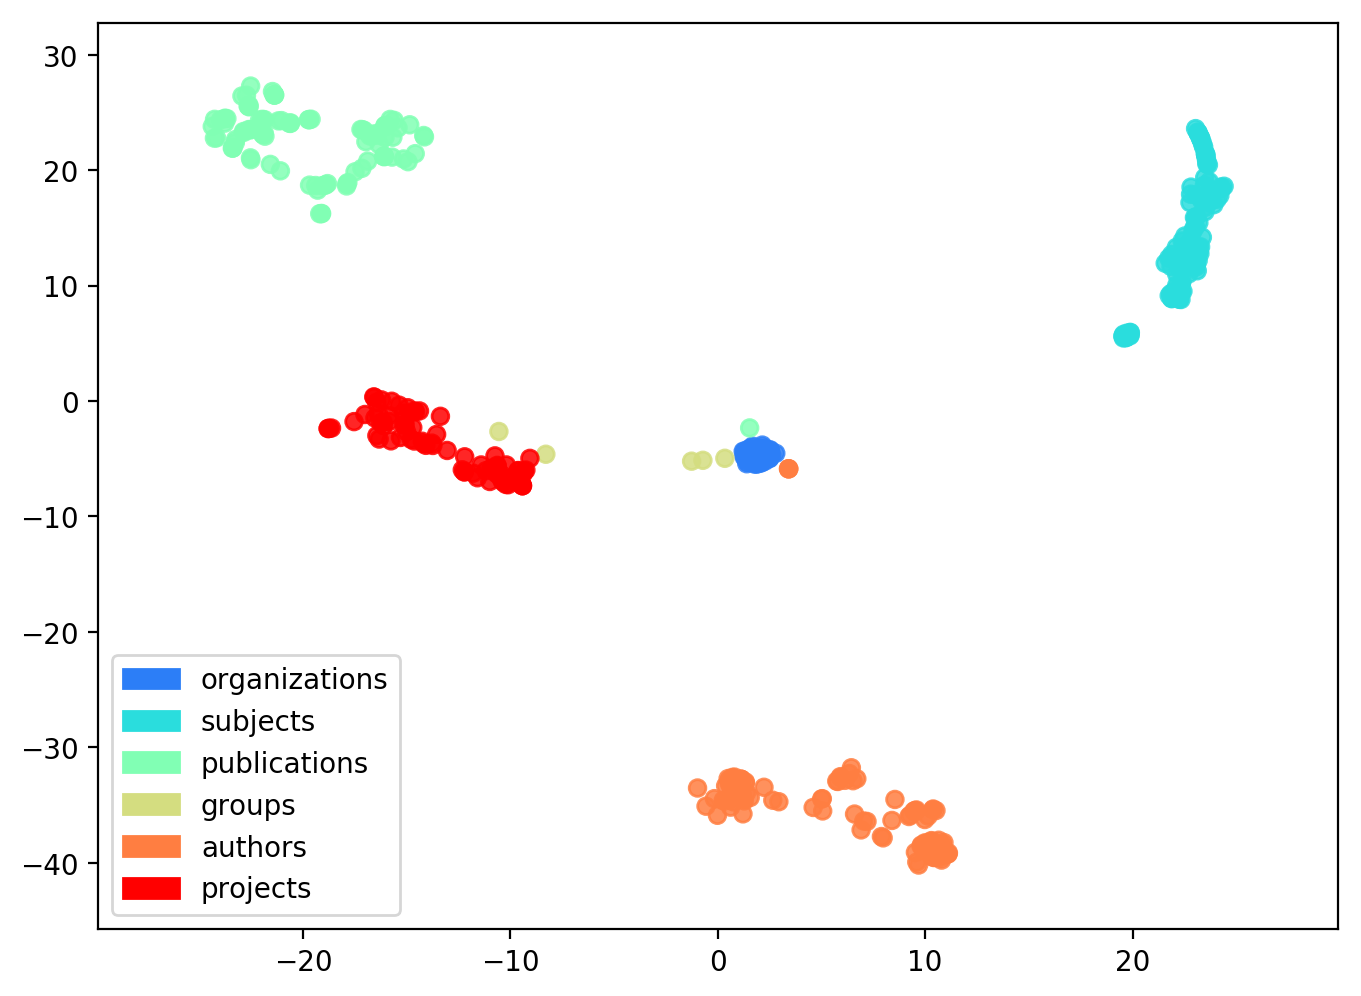

In [9]:
tsnescatterplot(subset_embeddings, subset_labels, label_enum)

In [10]:
import unicodecsv as csv

def get_sub_embeddings(full_embeddings, graph, filename):
    sub_dict = defaultdict(list)
    with open(filename, 'r') as csvfile:
        graphreader = csv.reader(csvfile)
        i = 0
        for row in graphreader:
            if i == 0:
                i += 1
                continue
            sub_dict[row[1].rsplit('/',2)[-1]].append(row[0])

    for k,v in sub_dict.iteritems():
        print(k,len(v))
    #get the embeddings for each of the people
    subset_embeddings = []
    subset_labels = []
    label_enum = list(enumerate(sub_dict.keys(),1))
    label_dict = {j: i for i,j in label_enum}

    for k,v in sub_dict.iteritems():
        for s in v:
            #print(s,embedding[op_graph.nodes[s]])
            subset_embeddings.append(full_embeddings[graph.nodes[s]])
            subset_labels.append(label_dict[k])
    print(label_enum)
    return subset_embeddings, subset_labels, label_enum

In [11]:
# The AIFB dataset has 176 people and they are associated with one of four affiliations in the organization.
# The completeSet.tsv file gives the URIs of the people and their affiliation
# (number, person, affiliation)

subset_embeddings, subset_labels, label_enum = get_sub_embeddings(embedding,op_graph,'aifb_csv/completeDataset.csv')

(u'id4instance', 15)
(u'id3instance', 60)
(u'id2instance', 28)
(u'id1instance', 73)
[(1, u'id4instance'), (2, u'id3instance'), (3, u'id2instance'), (4, u'id1instance')]


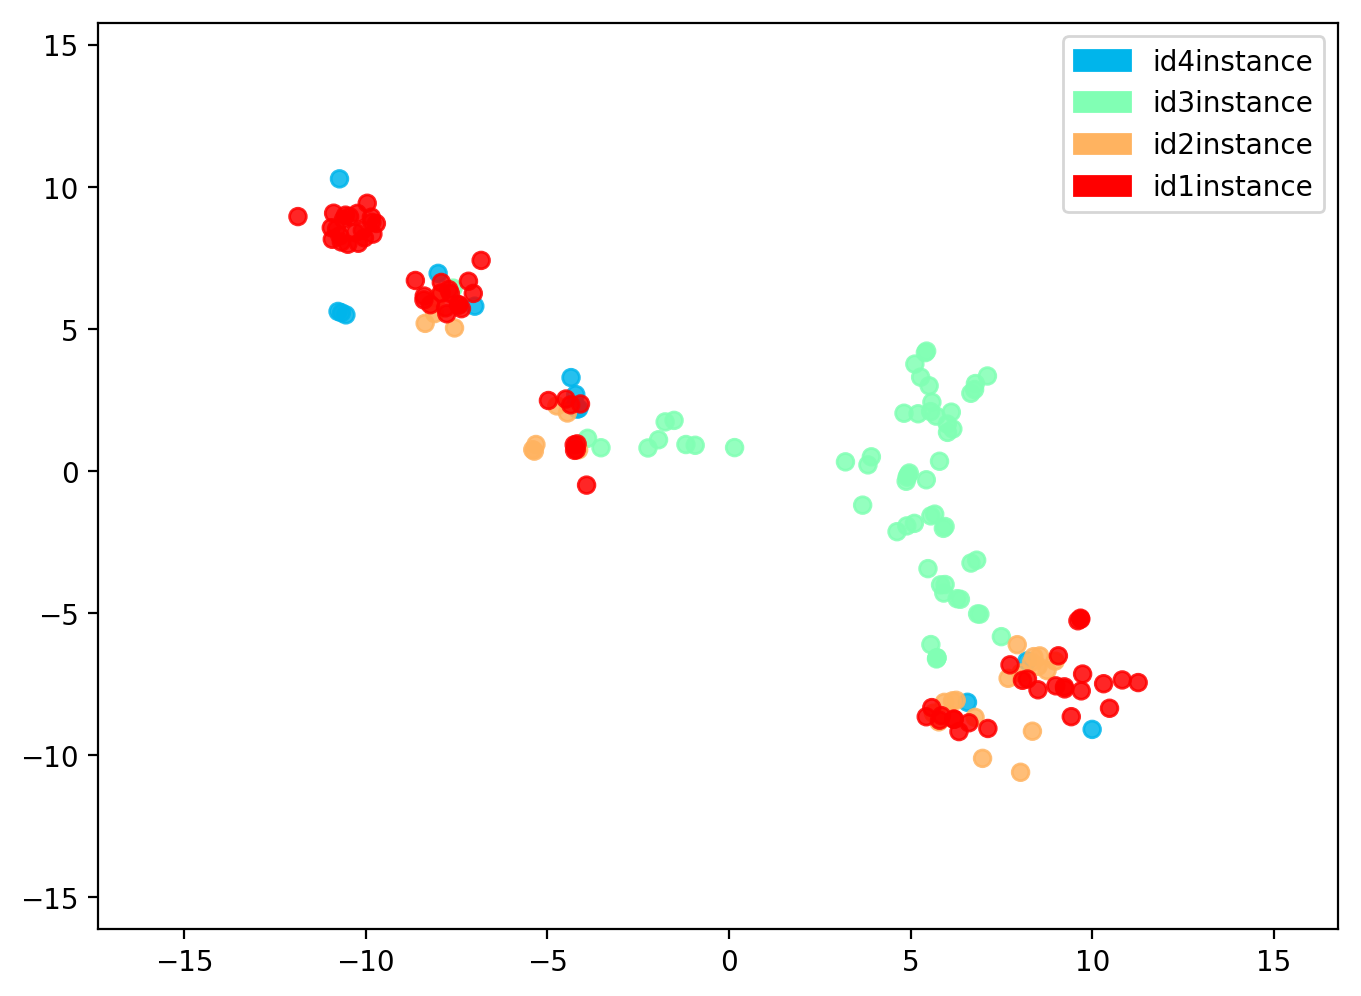

In [12]:
tsnescatterplot(subset_embeddings, subset_labels, label_enum)

In [13]:
subset_embeddings, subset_labels, label_enum = get_sub_embeddings(embedding,op_graph,'aifb_csv/project_carried_out.csv')


(u'id4instance', 5)
(u'id3instance', 43)
(u'id2instance', 18)
(u'id1instance', 12)
[(1, u'id4instance'), (2, u'id3instance'), (3, u'id2instance'), (4, u'id1instance')]


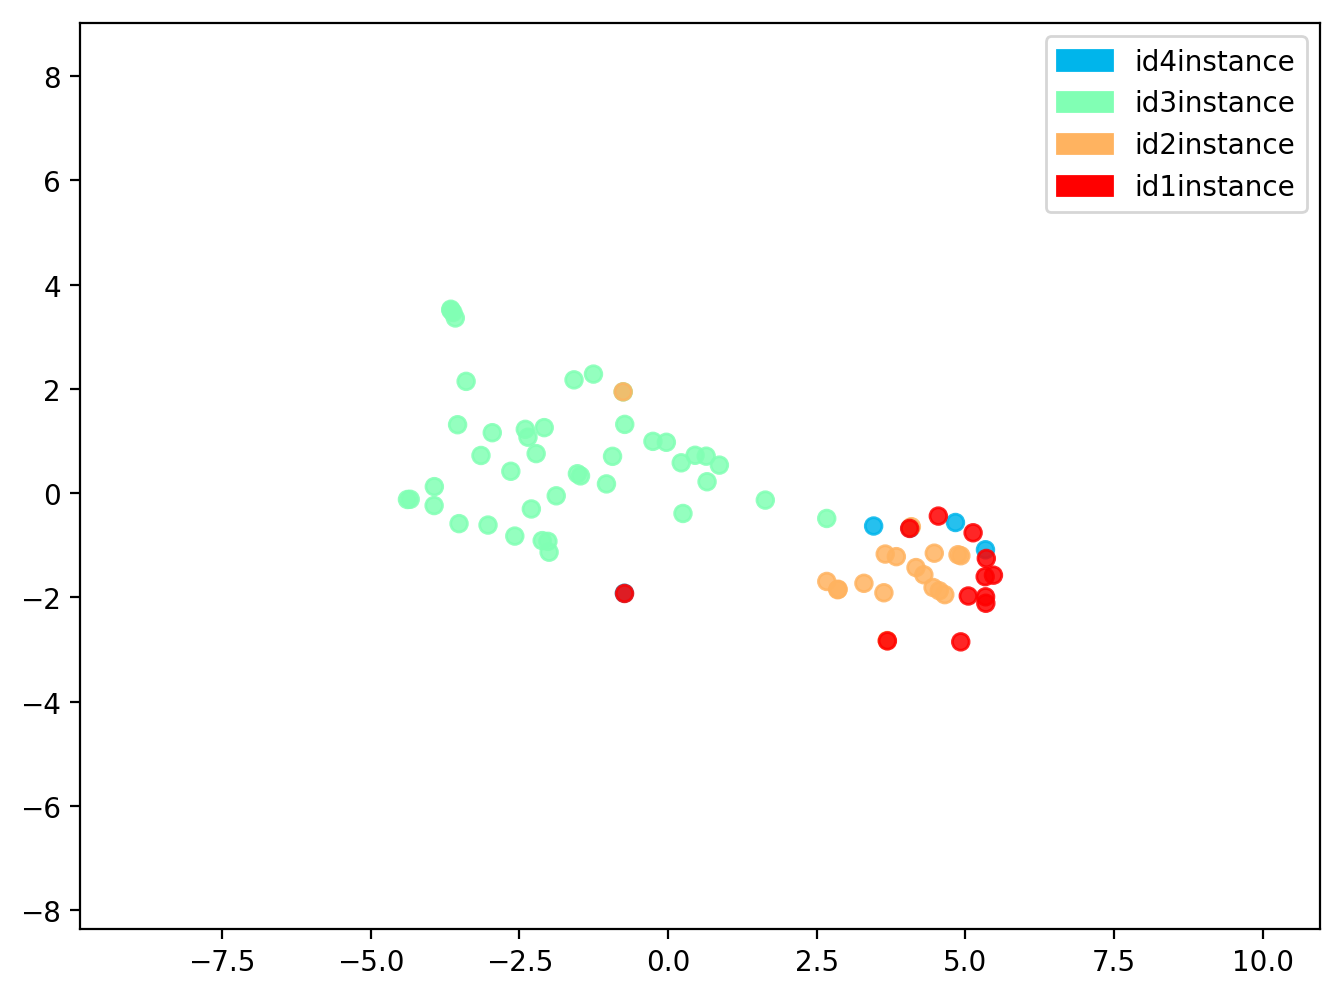

In [14]:
tsnescatterplot(subset_embeddings, subset_labels, label_enum)

In [15]:
finance_embeddings, finance_labels, finance_enum = get_sub_embeddings(embedding,op_graph,'aifb_csv/projects_financed.csv')

(u'id19instance', 1)
(u'id4instance', 1)
(u'id31instance', 1)
(u'id26instance', 2)
(u'id10instance', 1)
(u'id16instance', 1)
(u'id23instance', 1)
(u'id25instance', 1)
(u'id1instance', 1)
(u'id32instance', 2)
(u'id20instance', 2)
(u'id6instance', 3)
(u'id24instance', 1)
(u'id2instance', 8)
(u'id7instance', 9)
(u'id5instance', 12)
(u'id27instance', 2)
(u'id3instance', 13)
(u'id13instance', 1)
(u'id17instance', 1)
[(1, u'id19instance'), (2, u'id4instance'), (3, u'id31instance'), (4, u'id26instance'), (5, u'id10instance'), (6, u'id16instance'), (7, u'id23instance'), (8, u'id25instance'), (9, u'id1instance'), (10, u'id32instance'), (11, u'id20instance'), (12, u'id6instance'), (13, u'id24instance'), (14, u'id2instance'), (15, u'id7instance'), (16, u'id5instance'), (17, u'id27instance'), (18, u'id3instance'), (19, u'id13instance'), (20, u'id17instance')]


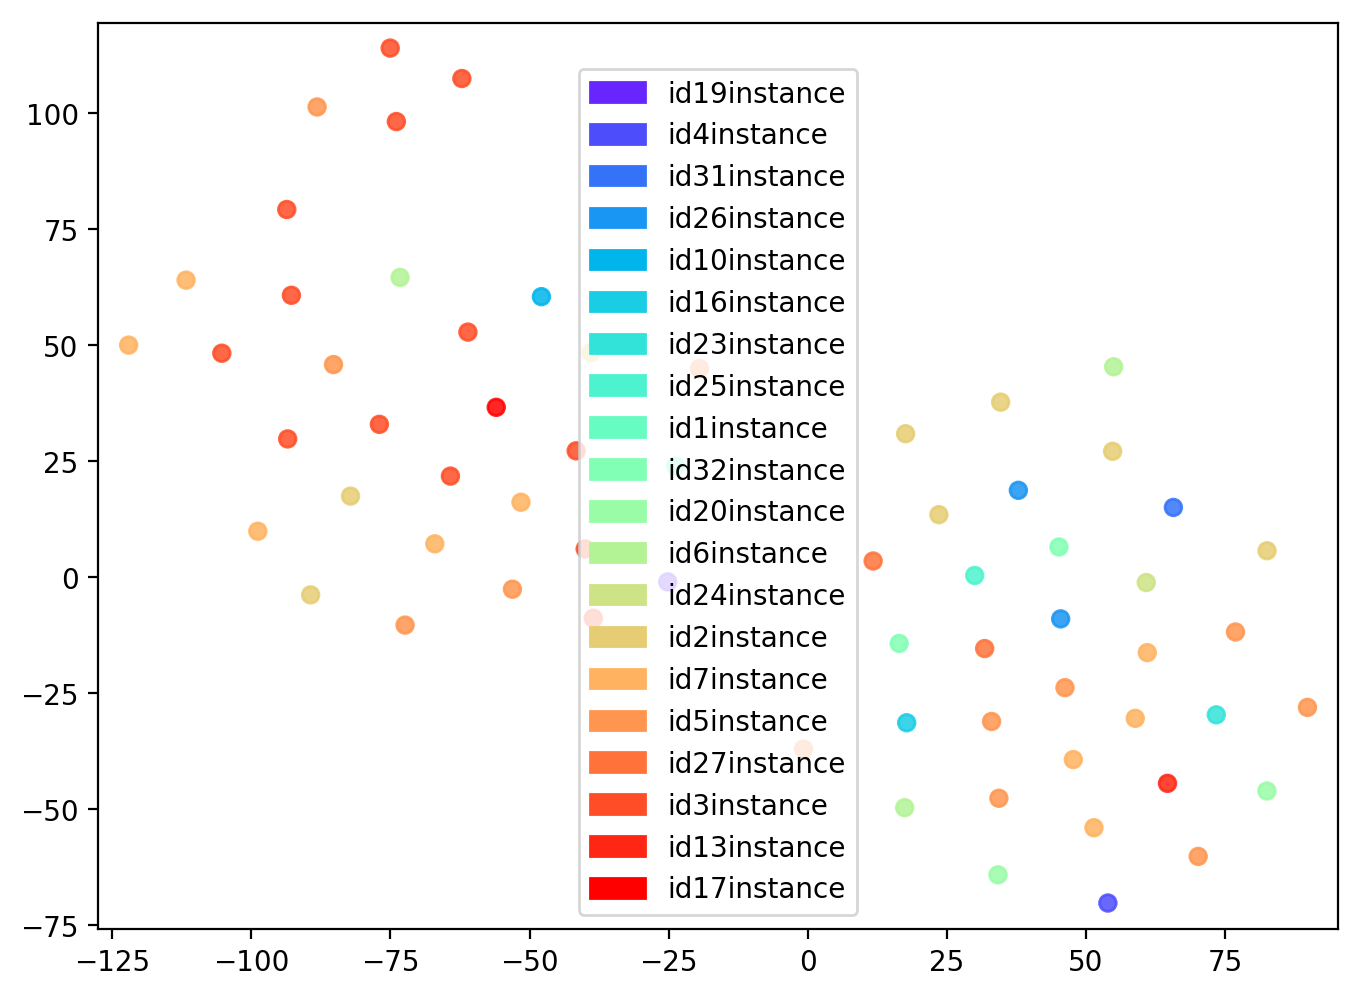

In [16]:
tsnescatterplot(finance_embeddings, finance_labels, finance_enum)
